In [3]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
all_annotations = pd.read_csv("../UCA-Dataset/uca_annotations.csv")

            mean   50%    max
split                        
test   18.890326  17.0  102.0
train  19.224086  17.0  129.0
val    17.781551  17.0   73.0


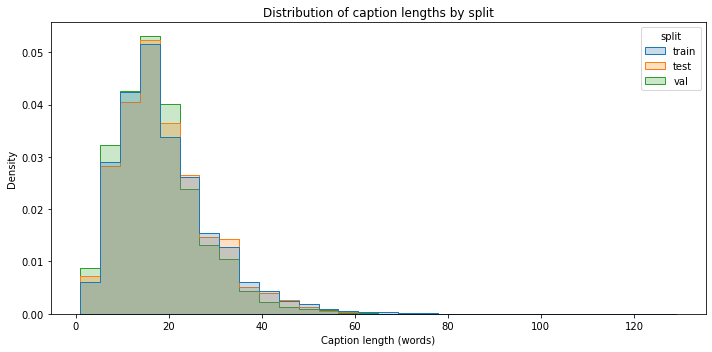

In [6]:
# clip_path is the unique clip identifier; keep only the needed columns
df_vis = all_annotations.copy()
df_vis['caption_len'] = df_vis['description'].fillna("").str.split().str.len()

print(df_vis.groupby('split')['caption_len'].describe()[['mean', '50%', 'max']])

plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_vis,
    x='caption_len',
    hue='split',
    bins=30,
    stat='density',
    element='step',
    common_norm=False
)
plt.title('Distribution of caption lengths by split')
plt.xlabel('Caption length (words)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [7]:
df_vis[df_vis['caption_len']<60].shape[0] / df_vis.shape[0]

0.9965168634780392

In [8]:
# ensure each clip counted once
uniq = df_vis.drop_duplicates('clip_path')

# count clips per folder/split
counts = (
    uniq.groupby(['folder', 'split'])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=['train', 'val', 'test'], fill_value=0)
)

# total clips per split to compute percentages
totals = counts.sum(axis=0).replace(0, pd.NA)

percentages = counts.divide(totals) * 100

# combine counts and percentages with clear column names
summary = pd.concat(
    {split: pd.DataFrame({
        'count': counts[split],
        'percent': percentages[split]
    }) for split in counts.columns},
    axis=1
)

summary = summary.sort_index()  # optional: keep folder order consistent
summary.columns = [f"{split}_{metric}" for split, metric in summary.columns]

summary.reset_index().rename(columns={'folder': 'Folder'})

,Folder,train_count,train_percent,val_count,val_percent,test_count,test_percent
0,Abuse,511,3.259552,108,3.056027,103,2.378204
1,Arrest,420,2.679084,87,2.461800,109,2.516740
2,Arson,123,0.784589,53,1.499717,91,2.101131
3,Assault,191,1.218345,37,1.046972,42,0.969753
4,Burglary,716,4.567200,152,4.301075,198,4.571692
5,Explosion,207,1.320406,78,2.207131,93,2.147310
6,Fighting,419,2.672705,130,3.678551,127,2.932348
7,Normal,10276,65.548255,2254,63.780419,2665,61.533133
8,RoadAccidents,441,2.813038,44,1.245048,134,3.093974
9,Robbery,722,4.605473,199,5.631013,213,4.918033


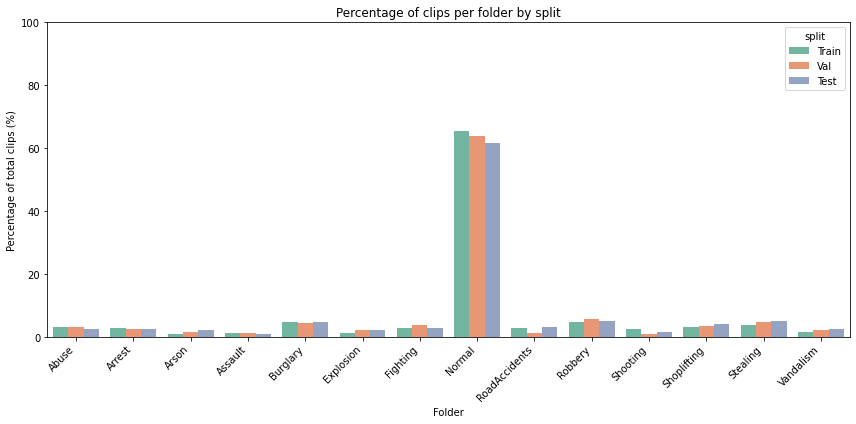

In [9]:
summary = summary.reset_index()  # ensure folder is a column

melted = summary.melt(
    id_vars='folder',
    value_vars=['train_percent', 'val_percent', 'test_percent'],
    var_name='split',
    value_name='percent'
)

melted['split'] = melted['split'].str.replace('_percent', '').str.capitalize()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted,
    x='folder',
    y='percent',
    hue='split',
    palette='Set2'
)
plt.title('Percentage of clips per folder by split')
plt.xlabel('Folder')
plt.ylabel('Percentage of total clips (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [10]:
from wordcloud import WordCloud, STOPWORDS

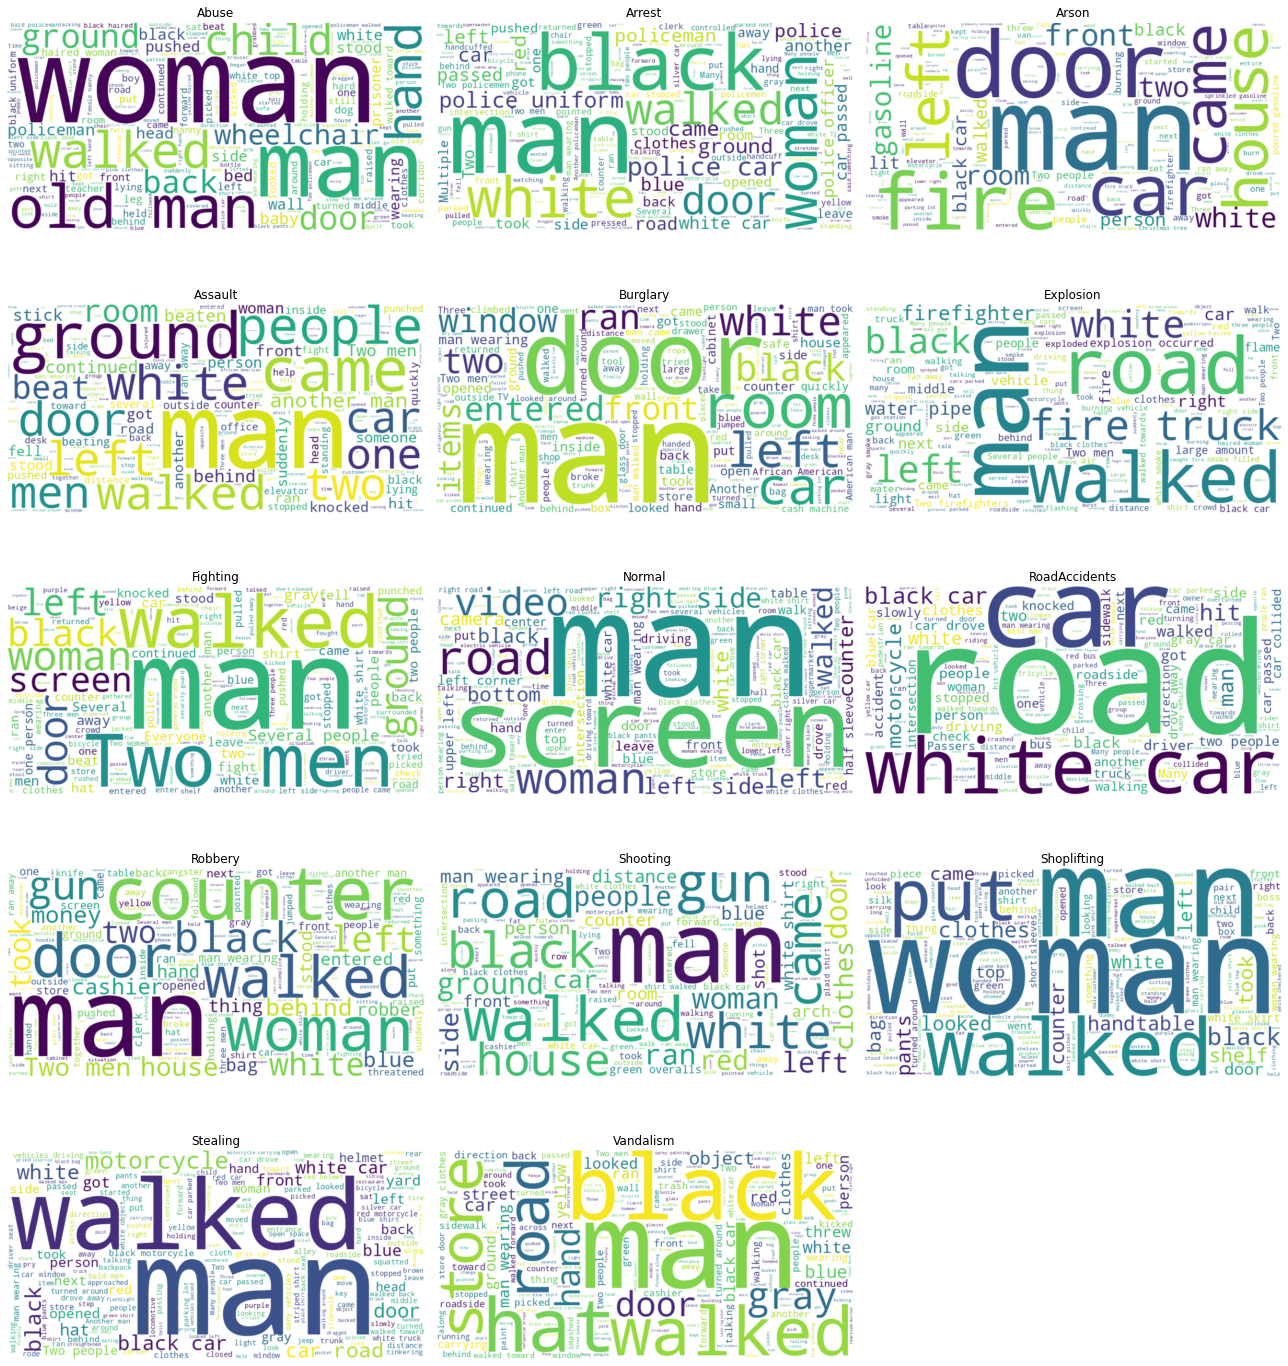

In [11]:
folders = df_vis['folder'].unique()
n = len(folders)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 4 * n_rows))
for idx, folder in enumerate(sorted(folders)):
    text = ' '.join(df_vis.loc[df_vis['folder'] == folder, 'description'])
    if not text.strip():
        continue
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS
    ).generate(text)

    ax = plt.subplot(n_rows, n_cols, idx + 1)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(folder)
    ax.axis('off')

plt.tight_layout()
plt.show()